In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [2]:
# read the test batches from files created by the Preprocessing_NN_Data notebook
def read_batches(filepath, include_cl_kadij_input=True):
    batches = []
    number_read = -1
    while True:
        number_read += 1
        try:
            batch = pd.read_csv(filepath + '_' + str(number_read) + '.csv', index_col=0, parse_dates=True)
            if not include_cl_kadij_input:
                batch = batch.drop('cl_kadij_1', 1)
            batches.append(batch)
        except FileNotFoundError:
            break
        
    return batches

#make sure this matches what was used to train the model or errors will occur due to different input sizes:
include_cl_kadij_input = True
test_batches = read_batches('data/test/batch', True)
basic_prediction = [batch['cl_kadij_1'].as_matrix() for batch in test_batches]
if not include_cl_kadij_input:
    test_batches = [batch.drop('cl_kadij_1', 1) for batch in test_batches]

In [3]:
#print an example batch to see what they look like
batch = test_batches[0]
batch.head()

,cl_kadij_out,cl_kadij_1,cl_lobith_3,cl_lobith_4,cl_lobith_5,cl_lobith_6,afv_lobith_6,afv_lobith_7,afv_lobith_8,afv_lobith_9,cum_stand_1,cum_stand_2
1982-02-20 16:00:00,0.416482,0.411501,0.597715,0.587056,0.552096,0.485198,0.410334,0.424792,0.437368,0.448504,0.279987,0.298631
1982-02-21 16:00:00,0.421333,0.416482,0.610702,0.597715,0.587056,0.552096,0.400456,0.410334,0.424792,0.437368,0.291536,0.279987
1982-02-22 16:00:00,0.423712,0.421333,0.607463,0.610702,0.597715,0.587056,0.394730,0.400456,0.410334,0.424792,0.273057,0.291536
1982-02-23 16:00:00,0.407675,0.423712,0.573957,0.607463,0.610702,0.597715,0.389205,0.394730,0.400456,0.410334,0.323379,0.273057
1982-02-24 16:00:00,0.398429,0.407675,0.552207,0.573957,0.607463,0.610702,0.383251,0.389205,0.394730,0.400456,0.392674,0.323379


In [4]:
# convert the dataframes in train_batches to the correct input and output shape (and make it arrays)
def convert_to_keras_input(batches):
    input_batches = []
    output_batches = []
    for batch in batches:
        input_df = batch.iloc[:,1:]
        output_df = batch['cl_kadij_out']
        input_batches.append(input_df.as_matrix()[:,np.newaxis,:])
        output_batches.append(output_df.as_matrix())
    return (input_batches, output_batches)

(input_test_batches, output_test_batches) = convert_to_keras_input(test_batches)

In [5]:
# load the trained model from a file
model_filename = 'models/2layer_lstm_11cells'

model = keras.models.load_model(model_filename + '.h5')
info_file = open(model_filename + '_info.txt')
info = ''
for line in info_file:
    info += line
info_file.close()
print('------- info of read model --------\n')
print(info)

------- info of read model --------

number of epochs: 1000
number of cells per layer: 11

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 11)             1012      
_________________________________________________________________
lstm_2 (LSTM)                (None, 11)                1012      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 2,036
Trainable params: 2,036
Non-trainable params: 0
_________________________________________________________________



In [6]:
# get the test results:
output_model = []
actual_value = []
for i in range(0,len(test_batches)):
    batch_model = model.predict(input_test_batches[i], batch_size = len(input_test_batches[i]))
    output_model.append([val for sublist in batch_model for val in sublist])
    actual_value.append(output_test_batches[i])

In [7]:
# load the scaler data from a file and define a function that retransforms the cl_kadij data to the actual values
scaler_data = pd.read_csv('data/scaler_data.csv', index_col=0)

def rescale_data(data,scaler_name):
    data_range = scaler_data.loc[scaler_name, 'data_range_']
    data_min = scaler_data.loc[scaler_name, 'data_min_']
    converted = np.array(data) * data_range + data_min
    return converted
    
def convert_cl_kadij_output(output):
    rescaled_output = rescale_data(output, 'cl_kadij_scaler')
    return np.exp(rescaled_output)

In [8]:
# rescale and transform data back to original values:
output_model_scaled = [convert_cl_kadij_output(output) for output in output_model]
actual_value_scaled = [convert_cl_kadij_output(output) for output in actual_value]
basic_prediction_scaled = [convert_cl_kadij_output(output) for output in basic_prediction]

In [9]:
# define some functions to calculate analysis of test results
def calculate_MSE(predicted, actual, start_index=0):
    '''calculates the MSE and returns it as well as the number of predictions and batches used to calculate it 
       returns (MSE, #predictions, #batches)
       @param predicted: array of arrays of outputs per batch
       @param actual: array of arrays of expected values per batch
       @param start_index: only values starting at the start_index will be used for MSE for each batch
    '''
    if len(predicted) != len(actual):
        raise ValueError('predicted and actual should contain the same number of batches')
    if start_index < 0:
        raise ValueError("can't start at a negative index")
    
    SE_sum = 0
    instance_count = 0
    batch_count = 0
    for i in range(0,len(predicted)):
        prediction = predicted[i]
        expected = actual[i]
        if (len(prediction) <= start_index):
            continue
        SE = (prediction[start_index:] - expected[start_index:])**2
        SE_sum += np.sum((prediction[start_index:] - expected[start_index:])**2)
        instance_count += len(prediction[start_index:])
        batch_count += 1
    
    if (instance_count == 0):
        raise ValueError('No output data available with this start_index')
    
    return (SE_sum / instance_count, instance_count, batch_count)

def calculate_prediction_skill(predicted, basic_predicted, actual, start_index=0):
    '''calculates the prediction skill compared to the basic prediction method and returns it
       returns (prediction_skill, MSE_model, MSE_basic, #predictions, #batches)'''
    (MSE_model, instance_count, batch_count) = calculate_MSE(predicted, actual, start_index)
    (MSE_basic, instance_count, batch_count) = calculate_MSE(basic_predicted, actual, start_index)
    prediction_skill = 1 - MSE_model / MSE_basic
    return (prediction_skill, MSE_model, MSE_basic, instance_count, batch_count)

In [10]:
# define a function to print the calculated analysis results:
def print_prediction_skill(prediction_skill, MSE_model, MSE_basic, instance_count, batch_count):
    print('prediction skill:', prediction_skill)
    print('MSE model:', MSE_model)
    print('MSE basic method:', MSE_basic)
    print('based on', instance_count, 'instances in', batch_count, 'batches')

In [11]:
#print analysis results for all test data:
print('--- Analysis done over all test data ---')
print_prediction_skill(*calculate_prediction_skill(output_model_scaled, basic_prediction_scaled, actual_value_scaled))

--- Analysis done over all test data ---
prediction skill: 0.41672537878
MSE model: 1684.17420866
MSE basic method: 2887.44640584
based on 42430 instances in 1399 batches


In [12]:
# calculate the prediction skill with differing start_index (start-up time ignored by analysis)
minimum_instances = 2000 
minimum_batches = 200

index = 0
prediction_skills = []
MSEs_model = []
MSEs_basic = []
instance_counts = []
batch_counts = []
while True:
    (prediction_skill, MSE_model, MSE_basic, instance_count, batch_count) = calculate_prediction_skill(output_model_scaled, basic_prediction_scaled, actual_value_scaled, start_index=index)
    prediction_skills.append(prediction_skill)
    if batch_count < minimum_batches or instance_count < minimum_instances:
        break
    MSEs_model.append(MSE_model)
    MSEs_basic.append(MSE_basic)
    instance_counts.append(instance_count)
    batch_counts.append(batch_count)
    index += 1

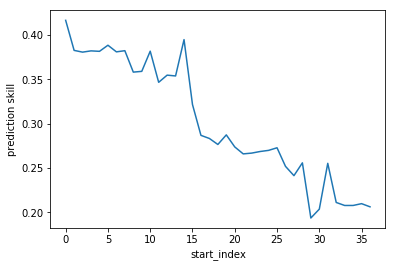

In [13]:
plt.plot(prediction_skills)
plt.xlabel('start_index')
plt.ylabel('prediction skill');

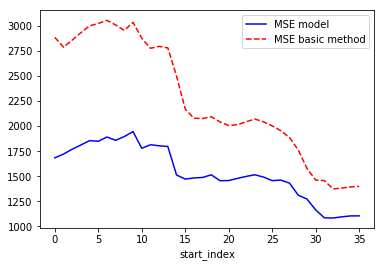

In [14]:
plt.plot(MSEs_model, 'b', label='MSE model')
plt.plot(MSEs_basic, 'r--', label='MSE basic method')
plt.xlabel('start_index')
plt.legend();

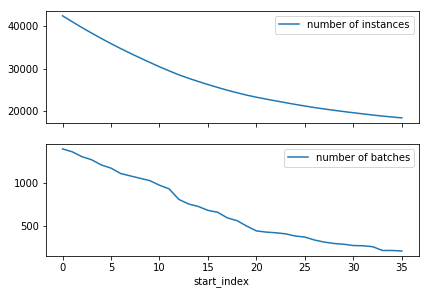

In [15]:
f, ax_array = plt.subplots(2, sharex=True)
f.tight_layout()
#f.xlabel('start_index')
ax_array[0].plot(instance_counts, label='number of instances')
ax_array[0].legend()
ax_array[1].plot(batch_counts, label='number of batches')
ax_array[1].legend()
f.text(0.5, 0.0, 'start_index', ha='center');

In [16]:
# old functions to calculate MSE and prediction skill still used by cell below
def print_MSE(predicted, actual, print_prefix='', start_index=0):
    '''calculates the MSE and prints it, returns the MSE'''
    errors = np.abs(predicted - actual)
    squared_errors = errors**2
    MSE = np.average(squared_errors)
    print(print_prefix + 'MSE:', MSE)
    return MSE

def print_prediction_skill_old(predicted, actual, basic_predicted, verbose=False):
    '''calculates the prediction skill compared to the basic prediction method of using the same value as yesterday
       the calculated prediction skill is printed and returned
       note that it calls the print_MSE function which will also print the MSE
       use verbose=True to also print the MSE of the basic prediction method'''
    MSE = print_MSE(predicted, actual)
    basic_errors = np.abs(actual - basic_predicted)
    basic_MSE = np.average(basic_errors**2)
    prediction_skill = 1 - MSE / basic_MSE
    if (verbose):
        print('MSE basic method:', basic_MSE)
    print('prediction skill:', prediction_skill)
    return prediction_skill

batch size 30

--- When analysing each data point in this batch ---
prediction skill: 0.324417687993
MSE model: 70.3055992695
MSE basic method: 104.066666667
based on 30 instances in 1 batches


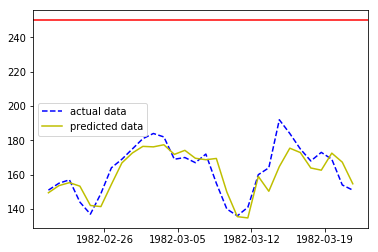

In [17]:
batch_index = 0
print('batch size', len(test_batches[batch_index]))
batch_output_model = model.predict(input_test_batches[batch_index], batch_size=len(input_test_batches[batch_index]))
batch_output_model = [val for subarray in batch_output_model for val in subarray]
batch_output_actual_converted = convert_cl_kadij_output(output_test_batches[batch_index])
batch_output_model_converted = convert_cl_kadij_output(batch_output_model)
batch_output_basic_converted = basic_prediction_scaled[batch_index]
plt.plot(test_batches[batch_index].index.values, batch_output_actual_converted, 'b--', label='actual data')
plt.plot(test_batches[batch_index].index.values, batch_output_model_converted, 'y', label='predicted data')
plt.axhline(250, color='red')
plt.legend();

print('\n--- When analysing each data point in this batch ---')
print_prediction_skill(*calculate_prediction_skill([batch_output_model_converted], [batch_output_basic_converted], [batch_output_actual_converted]))

In [18]:
# print the indices of big (>100) batches to use in the cell above
batch_sizes = [len(batch) for batch in test_batches]
print(np.where(np.array(batch_sizes) > 100))

(array([   7,   16,   19,   68,   72,   87,  101,  124,  142,  159,  174,
        177,  216,  218,  219,  251,  255,  257,  268,  314,  398,  418,
        426,  437,  449,  451,  470,  493,  498,  517,  524,  566,  581,
        585,  592,  624,  629,  642,  646,  648,  653,  676,  692,  696,
        718,  738,  742,  743,  756,  803,  812,  814,  815,  822,  825,
        829,  830,  841,  851,  865,  880,  894,  913,  918,  920,  928,
        936,  944, 1012, 1033, 1036, 1044, 1070, 1078, 1111, 1113, 1136,
       1147, 1161, 1184, 1186, 1190, 1246, 1249, 1303, 1318, 1319, 1324,
       1332, 1341, 1352, 1370, 1376], dtype=int64),)
